In [1]:
import os

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import geopandas as gpd

import muon as mu
import scanpy as sc
import squidpy as sq

In [2]:
# slide names and x, y offsets
slides = {'A1':[3.5, 18],
          'B1':[3, 10.5],
          'C1':[1, 13.5]}

In [3]:
path = os.path.join('..', 'data', 'sma')
exp = "V11L12-109" # V11T17-102 V11L12-109 V11T16-085

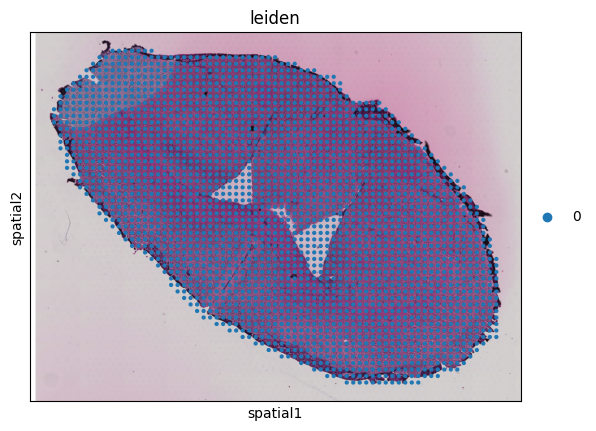

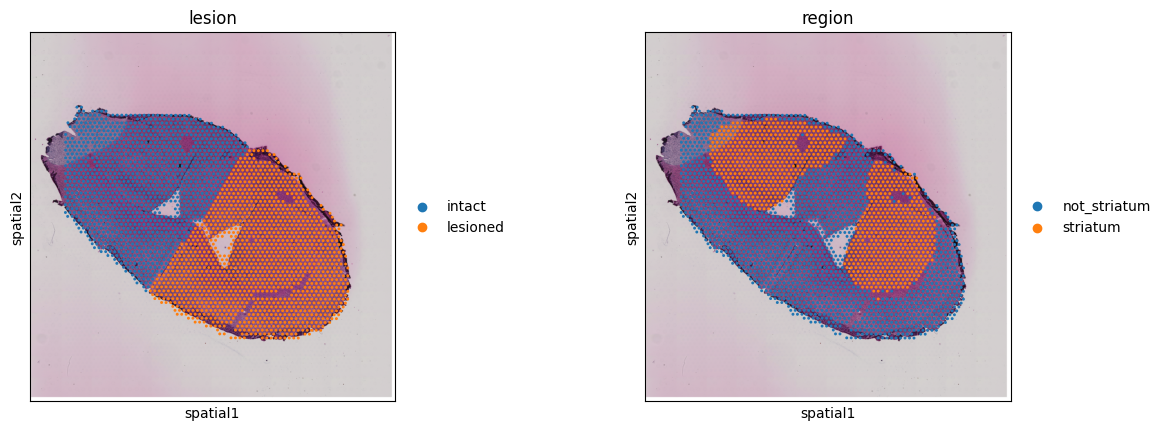

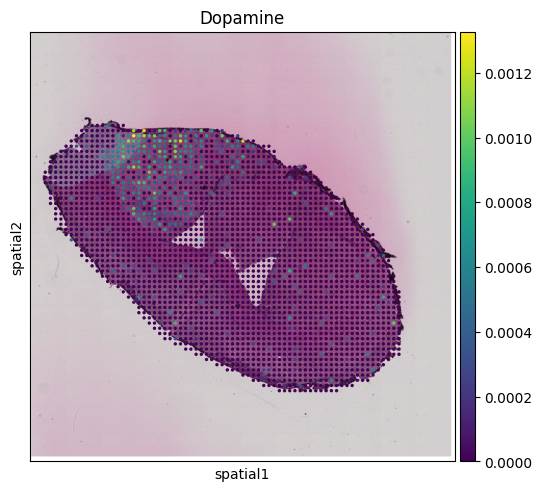

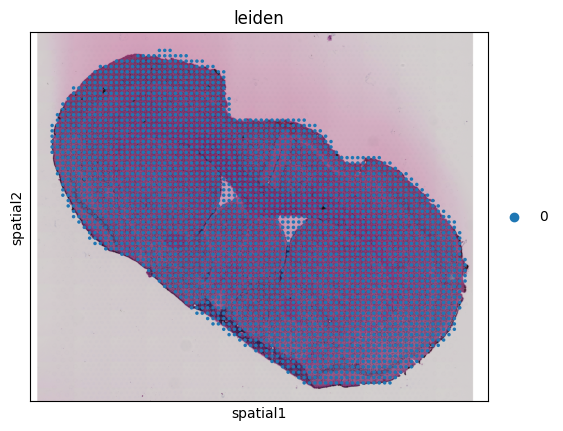

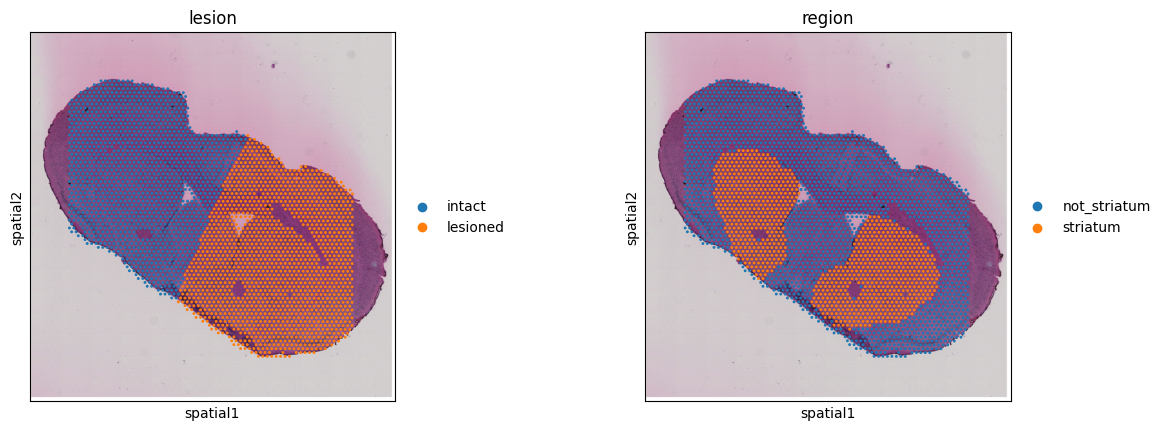

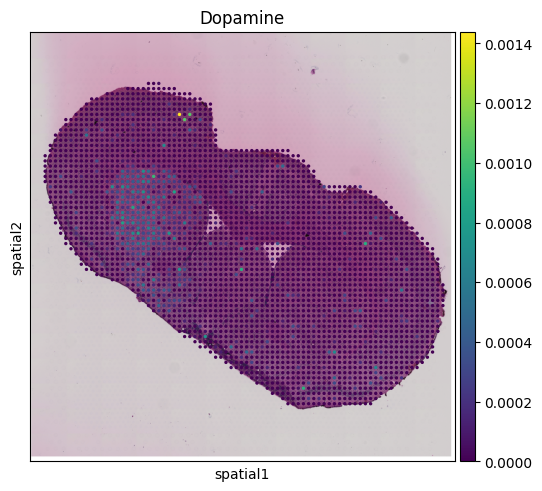

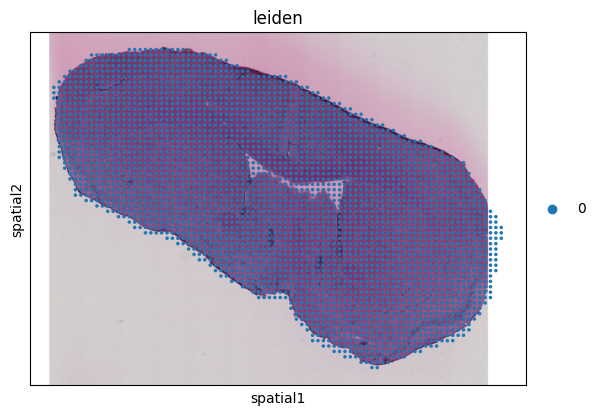

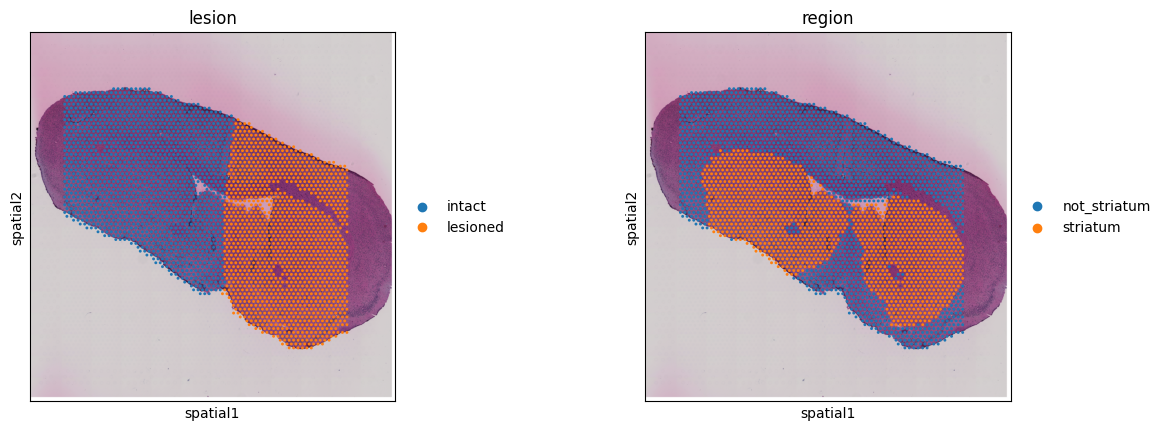

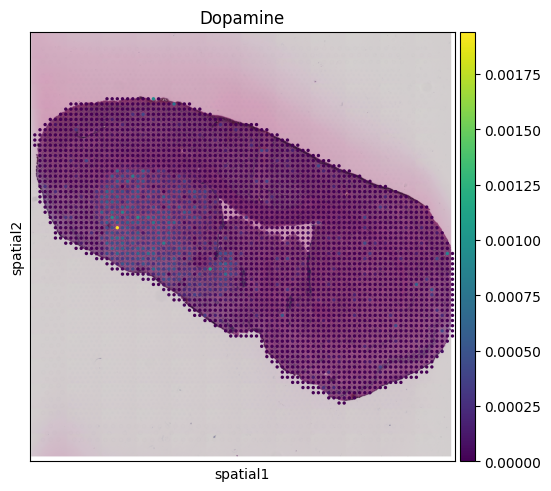

In [4]:
for slide in slides:
    slide_path = os.path.join(path, exp, f"{exp}_{slide}", "output_data")
    rna_path = os.path.join(slide_path, f"{exp}_{slide}_RNA", "outs")
    msi_path = os.path.join(slide_path, f"{exp}_{slide}_MSI" ,f"{exp}_{slide}.Visium.FMP.220826_smamsi.csv")
    
    rna = sq.read.visium(rna_path, counts_file="filtered_feature_bc_matrix.h5")
    rna.obs[['x', 'y']] = rna.obsm['spatial']

    msi_raw = pd.read_csv(msi_path)

    # set x and y columns as index, concat with _ as separator
    msi_raw.index = msi_raw[['x', 'y']].astype(str).agg('_'.join, axis=1)
    
    lesion = pd.read_csv(os.path.join(rna_path, "lesion.csv")).set_index("Barcode")
    region = pd.read_csv(os.path.join(rna_path, "region.csv")).set_index("Barcode")
    rna.obs = rna.obs.join(lesion)
    rna.obs = rna.obs.join(region)

    # NOTE: x and y are mirrored in the msi data
    positions = msi_raw[['y', 'x']].values.copy()

    # estimate scaling factor
    sfactor = rna.uns['spatial'][f"{exp}_{slide}"]['scalefactors']['fiducial_diameter_fullres']
    sfactor
    # inverse y
    positions[:, 0] = (positions[:, 0].max() - positions[:, 0])
    # offset
    x_offset = slides[slide][0]
    y_offset = slides[slide][1]

    positions[:, 0] = positions[:, 0] + x_offset
    positions[:, 1] = positions[:, 1] + y_offset

    array_row, array_col = positions[:,0], positions[:, 1]

    # scale
    positions = positions * sfactor * 0.95
    msi = msi_raw.copy().drop(['x', 'y'], axis=1)
    msi = sc.AnnData(X=msi.values,
                    obs=pd.DataFrame(index=msi.index),
                    var=pd.DataFrame(index=msi.columns)
                    )
    msi.obsm['spatial'] = positions
    msi.obs[['x', 'y']] = positions
    msi.obs['array_row'] = array_row
    msi.obs['array_col'] = array_col
    # copy raw intensities
    msi.layers['raw'] = msi.X.copy()
    msi.uns = rna.uns.copy()

    # normalize and cluster (as they do)
    sc.pp.normalize_total(msi, target_sum=1e4)
    sc.pp.log1p(msi)
    sc.pp.scale(msi)
    sc.pp.pca(msi)
    sc.pp.neighbors(msi, n_neighbors=10, n_pcs=20)
    sc.tl.leiden(msi, resolution=0.0002)
    # remove cells that are not in the tissue
    msi = msi[msi.obs['leiden'] != '1', :]
    sc.pl.spatial(msi, color="leiden")

    ## QC
    rna.var_names_make_unique()
    msi.var_names_make_unique()
    
    ### Process RNA
    sc.pp.filter_cells(rna, min_genes=200)
    sc.pp.filter_cells(rna, min_counts=100)
    sc.pp.filter_genes(rna, min_cells=3)
    rna.layers['counts'] = rna.X.copy()
    sc.pp.normalize_total(rna, target_sum=1e4)
    sc.pp.log1p(rna)

    ### Process metabolites
    msi.X = msi.layers['raw'].copy()
    # change type to float
    msi.var['mz'] = msi.var.index.astype(float)
    # round to 2 decimals
    msi.var['mz'] = [round(x, 2) for x in msi.var['mz']]
    msi.var['max_intensity'] = msi.X.sum(axis=0)
    msi.var['mz_raw'] = msi.var.index.astype(str)
    molecule_weights = {
        'GABA': 371.17556, # 371.18,
        'GABA-H2O': 353.16488, # 353.16 (rounding as in paper)
        'Taurine': 393.12718, # 393.13,
        'Serotonin': 444.20746, # 444.21,
        'Histidine': 423.18201, # NOTE: 423.18 Not in supp table
        '3-MT': 435.20706, # 435.21,
        'Dopamine (single)': 421.19146,
        'Dopamine': 674.28041, #  674.28,
        'DOPAC': 689.24381, # 698.24
        'Norepinephrine':690.27435, #  690.28,
        'Tocopherol': 698.49272 # 698.49
    }
    # round to 2 decimals
    molecule_weights = {k: round(v, 2) for k, v in molecule_weights.items()}
    
    # Join Conjugated molecules
    putative_molecules = pd.read_csv("../data/sma/putative_peaks.csv")
    putative_molecules = putative_molecules.set_index('metabolite')
    # pivot to long
    putative_molecules = putative_molecules.stack().reset_index()
    putative_molecules.rename(columns={'level_1':'peak', 0:'mz'}, inplace=True)
    putative_molecules['metabolite'] = putative_molecules['peak'] + " (" + putative_molecules['metabolite'] + ")"
    # round to mz to two decimals
    putative_molecules['raw_mz'] = putative_molecules['mz']
    putative_molecules['mz'] = [round(x, 2) for x in putative_molecules['mz']]
    # set as index, keep previous index as column
    putative_molecules = putative_molecules.set_index('metabolite', drop=False)
    # filter out molecules that are already in the data
    putative_molecules = putative_molecules[~putative_molecules['mz'].isin(molecule_weights.values())]
    molecules = pd.DataFrame.from_dict(molecule_weights, orient='index', columns=['mz'])
    molecules = pd.concat([molecules, putative_molecules])[['mz']].to_dict()['mz']

    msi.var['annotated'] = msi.var['mz'].map({v: k for k, v in molecules.items()})
    msi.var['annotated'] = msi.var['annotated'].astype('category')
    # if Name is NaN, then use mz_raw
    msi.var['name'] = msi.var.apply(lambda x: x['mz_raw'] if pd.isnull(x['annotated']) else x['annotated'], axis=1)
    msi.var['name'] = msi.var['name'].astype('str')
    msi.var.set_index('name', inplace=True)
    msi.var.index = msi.var.index.astype(str)

    # drop duplicates
    msi.X = msi.layers['raw'].copy()
    msi = msi[:, ~msi.var.index.duplicated()]
    sc.pp.filter_cells(msi, min_counts=200)
    sc.pp.normalize_total(msi, target_sum=1)

    # Transfer annotations
    rna_points = gpd.points_from_xy(rna.obs['x'], rna.obs['y'].values)
    msi_points = gpd.points_from_xy(msi.obs['x'], msi.obs['y'].values)
    original_gdf = gpd.GeoDataFrame(rna.obs[['region', 'lesion']], geometry=rna_points)
    target_gdf = gpd.GeoDataFrame(msi.obs, geometry=msi_points)
    # target_gdf to orginary df, without geometry
    target_df = pd.DataFrame(target_gdf.sjoin_nearest(original_gdf, how='left').drop(columns='geometry'))

    # fix region join (only for C1)
    if slide=="C1":
        target_df.loc[(target_df['array_row'] >= rna.obs['array_row'].max()) * (target_df['region'] =='striatum'), 'region'] = 'not_striatum'

    # annotations to msi
    msi.obs = target_df
    sq.pl.spatial_scatter(rna, color=['lesion', 'region'])

    # Write
    mdata = mu.MuData({'rna':rna, 'msi':msi})
    mdata = mu.MuData(mdata.mod)
    
    # swap back to raw intensities
    sq.pl.spatial_scatter(mdata.mod['msi'], color=['Dopamine']) # plot dopamine
    
    mdata.write_h5mu(os.path.join(slide_path, "sma.h5mu"))

Interpolate

In [ ]:
from scipy.sparse import lil_matrix
from scipy.interpolate import griddata
from anndata import AnnData

In [ ]:
reference = rna
target = msi
spatial_key = 'spatial'
verbose = True

In [ ]:
target_coords = target.obsm[spatial_key]
reference_coords = reference.obsm[spatial_key]

In [ ]:

X = lil_matrix((rna.shape[0], msi.shape[1]), dtype=np.float32) # lil matrix fill with zeroes

ad = AnnData(X=X,
             uns=reference.uns,
             obs=reference.obs,
             obsm=reference.obsm,
             obsp=reference.obsp, 
             var=msi.var, 
             varm=msi.varm
             )

ad.X = griddata(points=target_coords,
                xi=reference_coords, 
                values=target.X, 
                method='linear'
                )
    

In [ ]:
sc.pl.spatial(ad, color=['Dopamine'])